In [1]:
# Importation des librairies
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import statistics
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 50)
pd.options.mode.chained_assignment = None  # default='warn'

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/louisrageot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louisrageot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Fonctions utilisées dans le notebook

#### Réduction de dimension

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import RobustScaler


def pca_reduction(X):
    # Preserving 95% of the variance
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X)
    print(X_pca.shape)
    return(pca, X_pca)


def plot_PCA(pca):
    print(pca.explained_variance_ratio_)
    print(pca.explained_variance_ratio_.sum())

    ratios = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 5))
    plt.plot(range(len(ratios)), pca.explained_variance_ratio_)
    plt.xticks(range(len(ratios)))
    plt.title("Pourcentage de variance expliquée par composantes")
    plt.xlabel("Composante principale")
    plt.ylabel("% de variance expliquée")
    plt.show()


def tsne_reduction(X):
    tsne = TSNE(n_components=2, init='pca', perplexity=42, random_state=42)
    X_tsne = tsne.fit_transform(X)
    print(X_tsne.shape)
    return X_tsne


def tsne_visualization(tsne_result, y_pred, y_test, df, nc):

    X_normalized = RobustScaler().fit_transform(tsne_result)

    fig = plt.figure(1, figsize=(20, 10))
    plt.title('TSNE visualization')

    plt.subplot(1, 2, 1)
    plt.title('Reference set')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    sns.scatterplot(x=X_normalized[:, 0],
                    y=X_normalized[:, 1],
                    hue=y_test,
                    palette='tab10'
                    )

    plt.subplot(1, 2, 2)
    plt.title('Predicted set')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    sns.scatterplot(x=X_normalized[:, 0],
                    y=X_normalized[:, 1],
                    hue=y_pred,
                    palette='tab10'
                    )

    plt.show()

#### Clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


def KMeans_clustering(X_tsne, data, variable):
    n_clusters = data[variable].nunique()

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
    kmeans.fit(X_tsne)
    y_pred = kmeans.labels_  # Prédiction

    ARI_result = adjusted_rand_score(data[variable], kmeans.labels_)
    #Silhouette_result = silhouette_score(data[variable], kmeans.labels_)

    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(X_tsne)  # Fit the data to the visualizer
    visualizer.poof()  # Draw/show/poof the data

    print("ARI = "+str(ARI_result))

    return ARI_result, y_pred, kmeans

#### Métriques

In [4]:
def matrice_de_confusion(y_test, y_pred):
    # Create a DataFrame with labels and varieties as columns: df
    df = pd.DataFrame({'Labels': y_test, 'Clusters': y_pred})
    # Create crosstab: ct
    ct = pd.crosstab(df['Labels'], df['Clusters'])
    plt.figure(figsize = (6,4))
    sns.heatmap(ct, square=True, annot=True, fmt='d', cmap="viridis")
    plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

def graph_conf_matrix(y_test, y_pred, data, corresp=None):

    labels_n = data['cat_0'].sort_values().unique()
    y_test = LabelEncoder().fit_transform(data['cat_0'])

    conf_mat = confusion_matrix(y_test.astype(str), y_pred.astype(str))
    #print(conf_mat)
    
    if corresp is None:
        corresp = np.argmax(conf_mat, axis=0)
        print ("Correspondance des clusters : ", corresp)
    else:
        corresp = corresp
    
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_test, name="y_test").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    cls_labels_transform = labels['y_pred_transform']

    conf_mat = confusion_matrix(y_test.astype(str), cls_labels_transform.astype(str))

    df_cm = pd.DataFrame(conf_mat, index = [label for label in labels_n],
                  columns = [i for i in labels_n])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

#### Stockage des valeurs

In [6]:
ari_results = {}
#silhouette_results = {}
y_pred_results = {}
tsne_results = {}

# Exploration

In [7]:
data = pd.read_csv(
    '/Users/louisrageot/Desktop/OC DS/Projet 6 - Classifiez automatiquement des biens de consommation/Livrables/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [8]:
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [10]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [11]:
print('Unique Categories:', data['product_category_tree'].nunique())

Unique Categories: 642


## Split des arborescences de catégories

In [12]:
def find_max_category_tree():
    max = 0
    L = []
    for x in data['product_category_tree']:
        x = x.split('["')[1].split('"]')[0]
        temp = x.split(' >> ')
        L.append(len(temp))
        if len(temp) > max:
            max = len(temp)

    return(max, statistics.mean(L))


find_max_category_tree()

(7, 4.204761904761905)

In [13]:
# On split par [] puis par >>
def cat_levels(cat, lvl):
    cat = cat.split('["')[1].split('"]')[0]
    temp = cat.split(' >> ')
    if(len(temp)) == 4:
        temp = [temp[0], temp[1], temp[2], temp[3]]
    if(len(temp)) == 3:
        temp = [temp[0], temp[1], temp[2], 'None']
    if(len(temp)) == 2:
        temp = [temp[0], temp[1], 'None', 'None']
    if(len(temp)) == 1:
        temp = [temp[0], 'None', 'None', 'None']
    return temp[lvl]


# On se limite à 4 catégories max:
data['cat_0'] = data['product_category_tree'].apply(
    lambda cat: cat_levels(cat, 0))
data['cat_1'] = data['product_category_tree'].apply(
    lambda cat: cat_levels(cat, 1))
data['cat_2'] = data['product_category_tree'].apply(
    lambda cat: cat_levels(cat, 2))
data['cat_3'] = data['product_category_tree'].apply(
    lambda cat: cat_levels(cat, 3))

In [14]:
data[['product_category_tree', 'cat_0', 'cat_1', 'cat_2', 'cat_3']]

,product_category_tree,cat_0,cat_1,cat_2,cat_3
0,"[""Home Furnishing >> Curtains & Accessories >>...",Home Furnishing,Curtains & Accessories,Curtains,Elegance Polyester Multicolor Abstract Eyelet ...
1,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Sathiyas Baby Bath Towels
2,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",Baby Care,Baby Bath & Skin,Baby Bath Towels,Eurospa Baby Bath Towels
3,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,Bedsheets,SANTOSH ROYAL FASHION Bedsheets
4,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",Home Furnishing,Bed Linen,Bedsheets,Jaipur Print Bedsheets
...,...,...,...,...,...
1045,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Oren Empower Stickers
1046,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers
1047,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Uberlyfe Stickers
1048,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",Baby Care,Baby & Kids Gifts,Stickers,Wallmantra Stickers


## Distributions des catégories

In [15]:
def countplot(data, variable, top=None):
    plt.figure(figsize=(12, 6))

    g = sns.countplot(x=variable, data=data, orient='h',
                      order=data[variable].value_counts().head(top).index, palette='viridis_r')
    g.set_title(str.title(variable.replace(
        '_', ' '))+" Distribution")

    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    sizes = []
    total = len(data)
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
               height + 3,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=8)

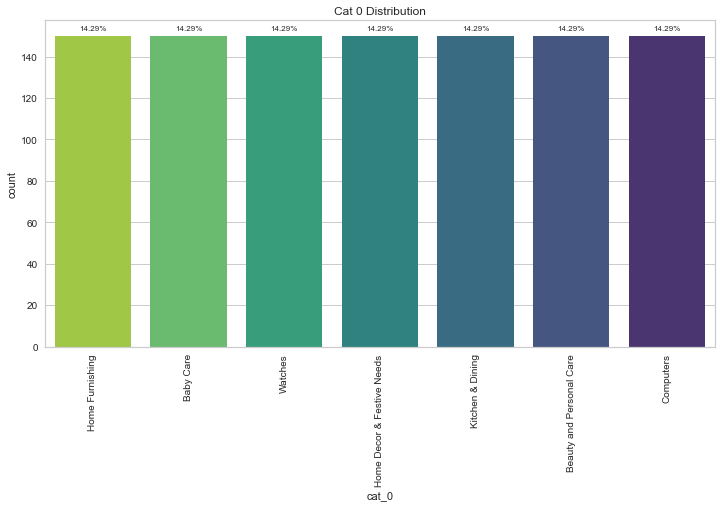

In [16]:
countplot(data, 'cat_0')

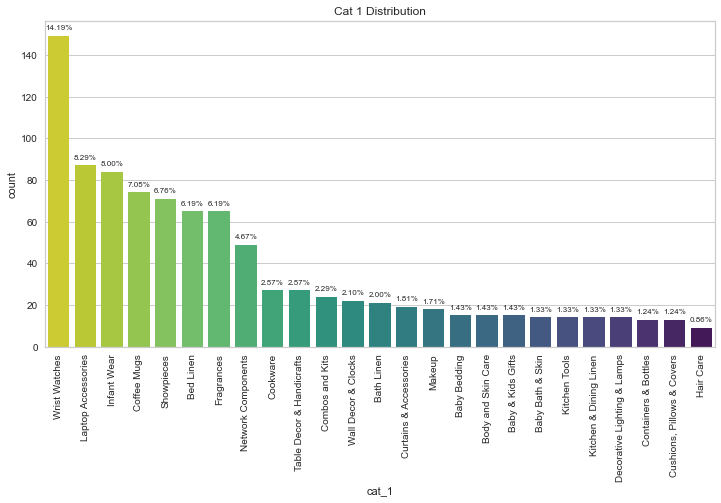

In [17]:
countplot(data, 'cat_1', top=25)

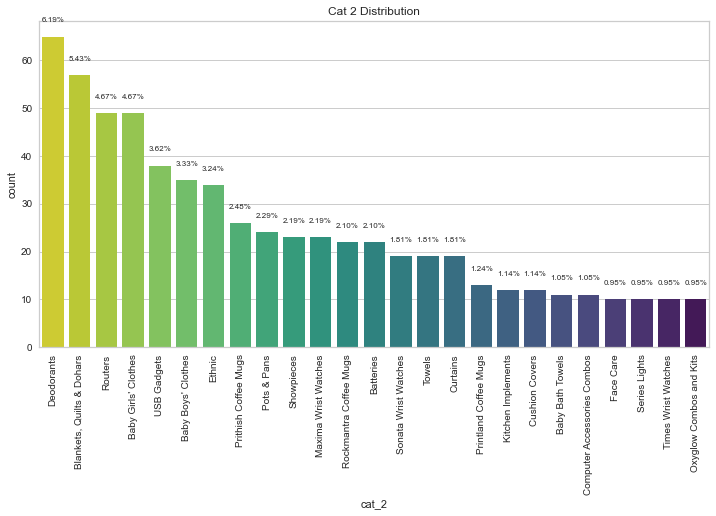

In [18]:
countplot(data, 'cat_2', top=25)

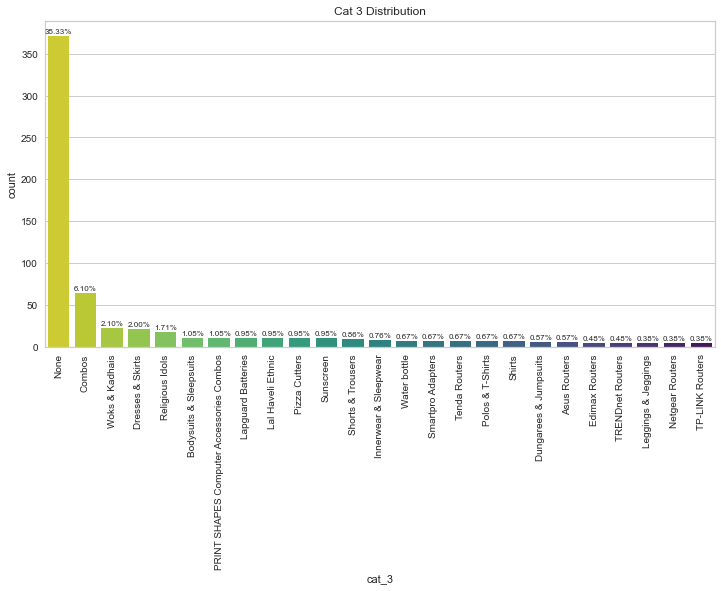

In [19]:
countplot(data, 'cat_3', top=25)

Nous utiliserons la catégorie 1 pour analyser la faisabilité.

# Données textuelles

## Preprocessing

In [20]:
pd.set_option('display.max_colwidth', None)
display(data[['description']].sample(5))
pd.set_option('display.max_colwidth', 50)

,description
116,"Recrafto Buddha Showpiece - 15.24 cm (Brass, Black, Green)\r\n Price: Rs. 3,500\r\n\t\t\t\t\r\n\t\t\tRecrafto Brass Buddha Religious Idols\r\nRecrafto Brass Buddha Religious Idols"
338,Flipkart.com: Buy Adidas Get Ready and Natural Vitality Combo Set online only for Rs. 320 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
392,"Flipkart.com: Buy Wild Stone Drift,Wave Combo Set online only for Rs. 355 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
335,Buy Tenda A5 only for Rs. 2250 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
919,Buy Anjalika Brass Laddu Gopal Showpiece - 6 cm for Rs.900 online. Anjalika Brass Laddu Gopal Showpiece - 6 cm at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.


In [21]:
ex = data['description'].iloc[1]
ex

'Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel'

### Lower

In [22]:
ex = ex.lower()
print("Lower\n"+str(ex))

Lower
specifications of sathiyas cotton bath towel (3 bath towel, red, yellow, blue) bath towel features machine washable yes material cotton design self design general brand sathiyas type bath towel gsm 500 model name sathiyas cotton bath towel ideal for men, women, boys, girls model id asvtwl322 color red, yellow, blue size mediam dimensions length 30 inch width 60 inch in the box number of contents in sales package 3 sales package 3 bath towel


### Tokenizer

In [23]:
ex = word_tokenize(ex)
print("Tokenizer\n"+str(ex))

Tokenizer
['specifications', 'of', 'sathiyas', 'cotton', 'bath', 'towel', '(', '3', 'bath', 'towel', ',', 'red', ',', 'yellow', ',', 'blue', ')', 'bath', 'towel', 'features', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'sathiyas', 'type', 'bath', 'towel', 'gsm', '500', 'model', 'name', 'sathiyas', 'cotton', 'bath', 'towel', 'ideal', 'for', 'men', ',', 'women', ',', 'boys', ',', 'girls', 'model', 'id', 'asvtwl322', 'color', 'red', ',', 'yellow', ',', 'blue', 'size', 'mediam', 'dimensions', 'length', '30', 'inch', 'width', '60', 'inch', 'in', 'the', 'box', 'number', 'of', 'contents', 'in', 'sales', 'package', '3', 'sales', 'package', '3', 'bath', 'towel']


### Stopwords

In [24]:
from string import punctuation

stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords = stopwords.union(punctuation)
stopwords

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [25]:
ex = [word for word in ex if not word in stopwords]
print('Stopwords\n'+str(ex))

Stopwords
['specifications', 'sathiyas', 'cotton', 'bath', 'towel', '3', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'features', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'sathiyas', 'type', 'bath', 'towel', 'gsm', '500', 'model', 'name', 'sathiyas', 'cotton', 'bath', 'towel', 'ideal', 'men', 'women', 'boys', 'girls', 'model', 'id', 'asvtwl322', 'color', 'red', 'yellow', 'blue', 'size', 'mediam', 'dimensions', 'length', '30', 'inch', 'width', '60', 'inch', 'box', 'number', 'contents', 'sales', 'package', '3', 'sales', 'package', '3', 'bath', 'towel']


### Lemmatizer

In [26]:
lemmatizer = WordNetLemmatizer()
ex = [lemmatizer.lemmatize(w) for w in ex]
print("Lemmatizer\n"+str(ex))

Lemmatizer
['specification', 'sathiyas', 'cotton', 'bath', 'towel', '3', 'bath', 'towel', 'red', 'yellow', 'blue', 'bath', 'towel', 'feature', 'machine', 'washable', 'yes', 'material', 'cotton', 'design', 'self', 'design', 'general', 'brand', 'sathiyas', 'type', 'bath', 'towel', 'gsm', '500', 'model', 'name', 'sathiyas', 'cotton', 'bath', 'towel', 'ideal', 'men', 'woman', 'boy', 'girl', 'model', 'id', 'asvtwl322', 'color', 'red', 'yellow', 'blue', 'size', 'mediam', 'dimension', 'length', '30', 'inch', 'width', '60', 'inch', 'box', 'number', 'content', 'sale', 'package', '3', 'sale', 'package', '3', 'bath', 'towel']


### Preprocessing function

In [27]:
import re
from nltk.stem import WordNetLemmatizer

# init lemmatizer
lemmatizer = WordNetLemmatizer()


def text_preprocessor(text):

    # text lower
    text = text.lower()

    # remove html markup
    text = re.sub("(<.*?>)", "", text)

    # remove non-ascii and digits
    text = re.sub("(\\W|\\d)", " ", text)

    # remove whitespace
    text = text.strip()

    # lemmatize words
    words = re.split("\\s+", text)
    lemmatized_words = [lemmatizer.lemmatize(word=word) for word in words]
    return ' '.join(lemmatized_words)

## Text to Vector

### Bag of words

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(preprocessor=text_preprocessor,
                      stop_words=stopwords, min_df=2)

bow_vector = bow.fit_transform(data['description'])


bow_df = pd.DataFrame(bow_vector.toarray(), columns=bow.get_feature_names())
print(bow_df.shape)
bow_df

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(1050, 2133)


,_b,aa,aapno,ability,able,abode,absorbency,absorbent,abstract,ac,accent,access,accessory,accident,accidental,according,across,act,actual,adapter,adaptor,add,addition,additional,adhesive,...,wrap,wrapped,wrapper,wring,wrinkle,wrist,write,xl,yardley,yarn,year,yellow,yes,yet,yl,ym,york,young,youth,youthful,yuva,zero,zipper,zone,zyxel
0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# bow.vocabulary_

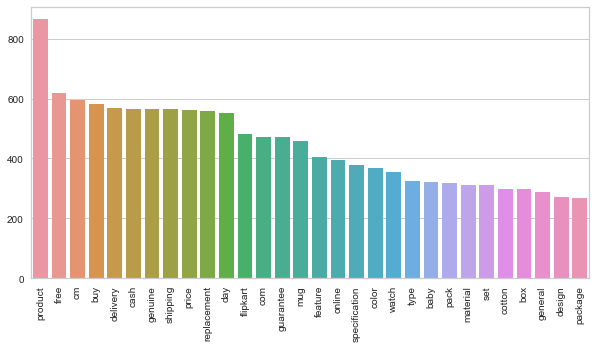

In [30]:
plt.figure(figsize=(10, 5))
occ = sns.barplot(data=bow_df.sum().sort_values(
    ascending=False).to_frame().head(30).T)
for item in occ.get_xticklabels():
    item.set_rotation(90)

(1050, 257)
[0.07159235 0.06283209 0.05581195 0.03260682 0.02951865 0.02328311
 0.02148867 0.02063029 0.0178922  0.01672241 0.01658107 0.0154171
 0.01472044 0.01390077 0.01319979 0.01300088 0.01123668 0.01102675
 0.01059616 0.00979826 0.00922658 0.00877563 0.00866598 0.0083267
 0.00810461 0.00768384 0.00751918 0.00729424 0.00725877 0.00700502
 0.00685141 0.00672571 0.00659498 0.00639988 0.00615386 0.00585793
 0.00577504 0.00559741 0.00554648 0.00544125 0.00526881 0.0051903
 0.00491981 0.00481266 0.00462776 0.00447807 0.00430903 0.00427826
 0.00422049 0.00410764 0.00405253 0.00398892 0.00390969 0.00380421
 0.00366696 0.00363759 0.0035835  0.00347482 0.00342339 0.00338316
 0.00333327 0.00327173 0.00326388 0.00313248 0.00310601 0.00303004
 0.00298862 0.00289712 0.00287818 0.00286335 0.00283584 0.00276935
 0.00274391 0.00270378 0.00268328 0.00264613 0.00263285 0.00260599
 0.00257052 0.00252596 0.00248218 0.00244036 0.00242754 0.00236866
 0.00233755 0.00232386 0.00227653 0.00224537 0.002221

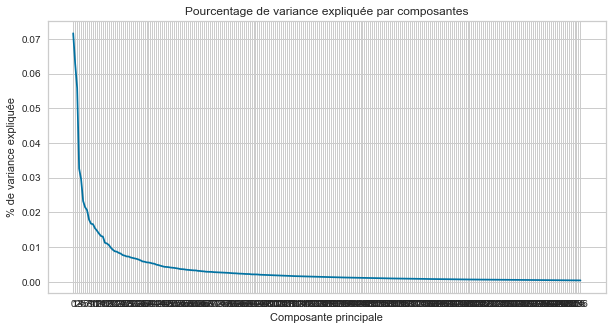

In [31]:
pca, x = pca_reduction(bow_df)
plot_PCA(pca)

In [33]:
tsne_result = tsne_reduction(x)
tsne_results['BOW+KMeans'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


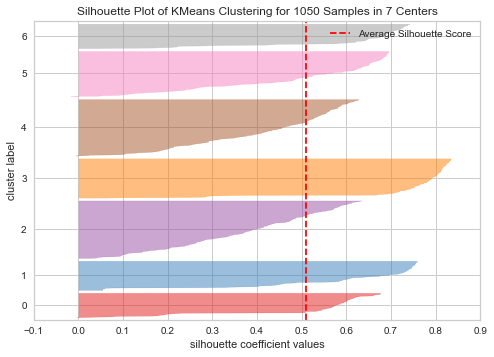

ARI = 0.443135971540995


In [34]:
result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['BOW+KMeans'] = result

In [35]:
y_pred_results['BOW+KMeans'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.443135971540995


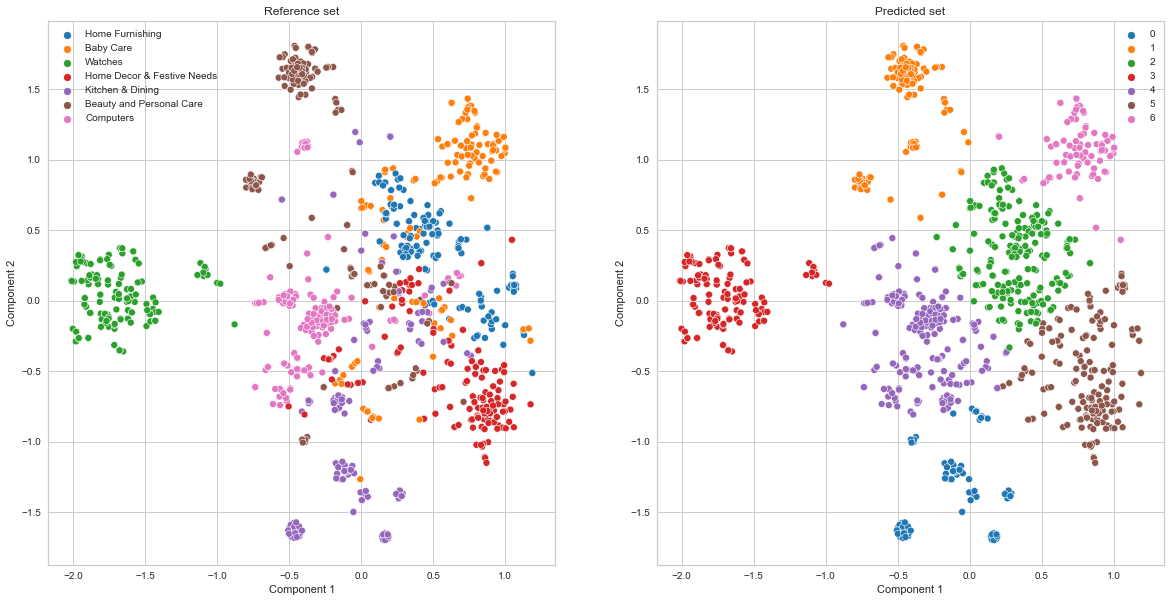

In [36]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

Correspondance des clusters :  [5 1 4 6 2 3 0]


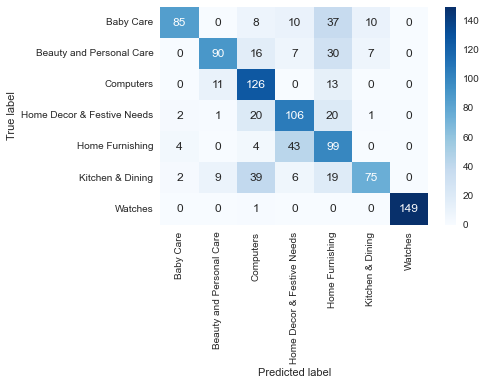

In [37]:
graph_conf_matrix(y_test, y_pred, data=data)

### TF-IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor=text_preprocessor,
                        stop_words=stopwords, min_df=2)

tfidf_vector = tfidf.fit_transform(data['description'])
tfidf_df = pd.DataFrame(tfidf_vector.toarray(),
                        columns=tfidf.get_feature_names())
print(tfidf_df.shape)
tfidf_df

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(1050, 2133)


,_b,aa,aapno,ability,able,abode,absorbency,absorbent,abstract,ac,accent,access,accessory,accident,accidental,according,across,act,actual,adapter,adaptor,add,addition,additional,adhesive,...,wrap,wrapped,wrapper,wring,wrinkle,wrist,write,xl,yardley,yarn,year,yellow,yes,yet,yl,ym,york,young,youth,youthful,yuva,zero,zipper,zone,zyxel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.175894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.072662,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.196071,0.076832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.074497,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.045833,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.041846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.034300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.042500,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.118859,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1047,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1048,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# tfidf.vocabulary_

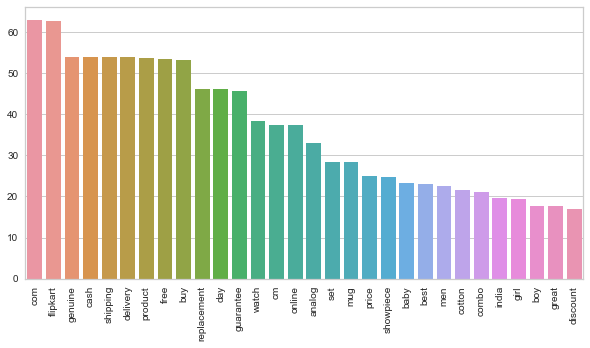

In [40]:
plt.figure(figsize=(10, 5))
occ = sns.barplot(data=tfidf_df.sum().sort_values(
    ascending=False).to_frame().head(30).T)
for item in occ.get_xticklabels():
    item.set_rotation(90)

(1050, 497)
[0.05368426 0.03245574 0.02611765 0.02198475 0.016679   0.01490305
 0.01461891 0.01299985 0.01195798 0.01114781 0.00969162 0.00911929
 0.0086036  0.00827992 0.00818121 0.00754476 0.00749098 0.00733118
 0.00712236 0.00705703 0.00694092 0.00670346 0.00668198 0.00653681
 0.00616453 0.00584368 0.00579152 0.00548983 0.00532054 0.00523613
 0.00511808 0.00491106 0.00475959 0.00472035 0.00459976 0.00453194
 0.00448501 0.00437969 0.00425522 0.00417876 0.00412675 0.00401941
 0.00394294 0.00389429 0.00378517 0.00374528 0.00366577 0.00365694
 0.00358447 0.00354626 0.00352313 0.00344878 0.00339098 0.00336488
 0.0033229  0.00325067 0.00318074 0.00316202 0.0031353  0.00311323
 0.00309707 0.00303712 0.00302931 0.00295465 0.00294728 0.00292059
 0.00287659 0.00285066 0.00282947 0.00280063 0.0027678  0.00272436
 0.00269858 0.00268448 0.00265608 0.00264519 0.00263399 0.00257773
 0.00256222 0.00254295 0.00250957 0.00249169 0.00245832 0.00245285
 0.00242758 0.002411   0.00239542 0.00237282 0.002

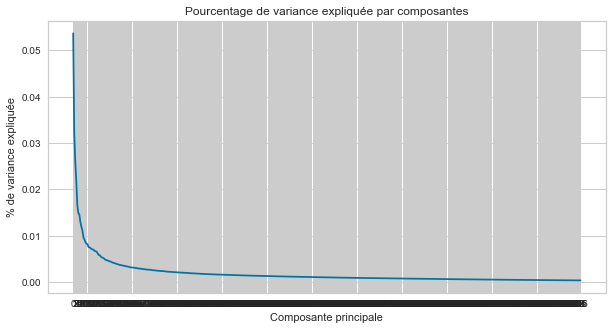

In [41]:
pca, x = pca_reduction(tfidf_df)
plot_PCA(pca)

In [42]:
tsne_result = tsne_reduction(x)
tsne_results['TFIDF+KMeans'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


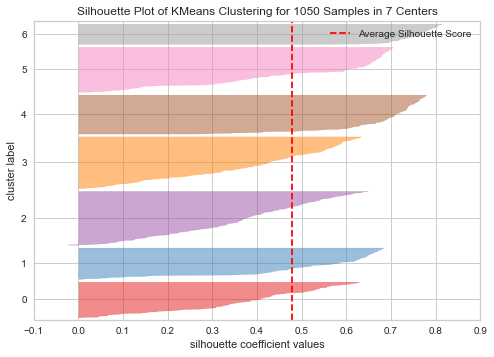

ARI = 0.44844261701881843


In [43]:
result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['TFIDF+KMeans'] = result

In [44]:
y_pred_results['TFIDF+KMeans'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.44844261701881843


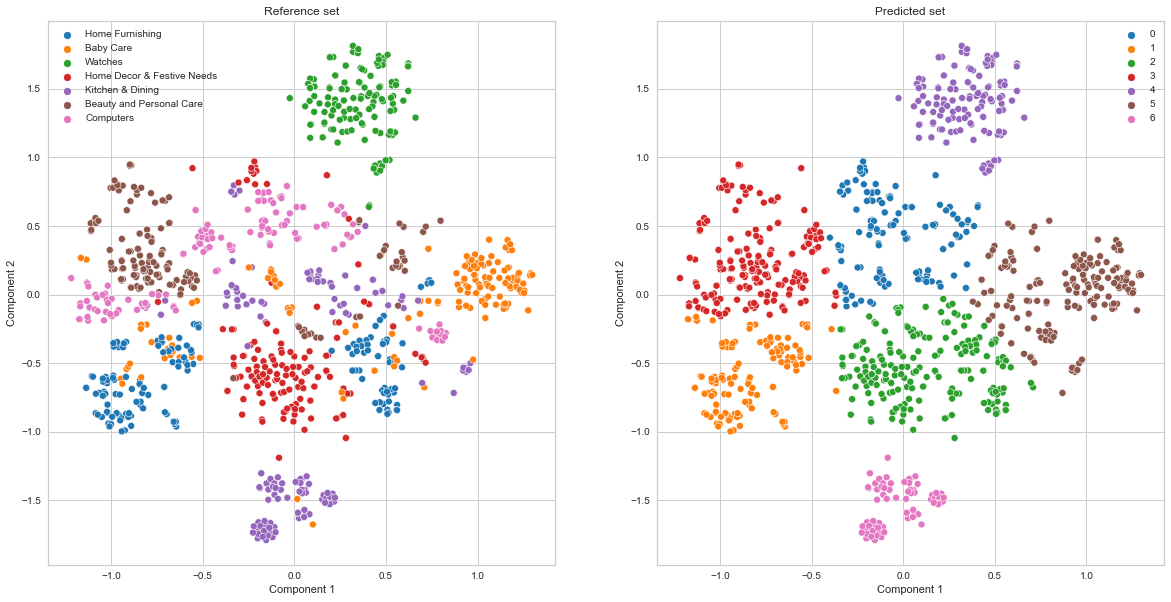

In [45]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

In [46]:
y_pred

array([2, 1, 1, ..., 0, 0, 0], dtype=int32)

Correspondance des clusters :  [2 4 3 1 6 0 5]


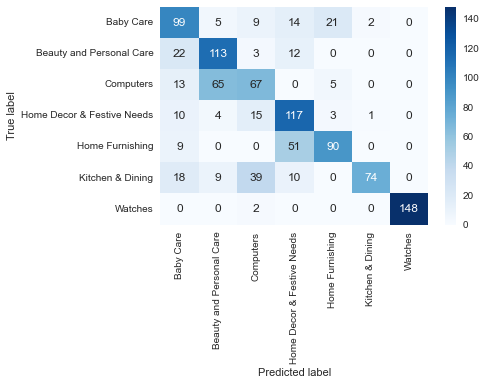

In [47]:
graph_conf_matrix(y_test, y_pred, data=data)

## Topic modeling

In [48]:
y_test

array(['Home Furnishing', 'Baby Care', 'Baby Care', ..., 'Baby Care',
       'Baby Care', 'Baby Care'], dtype=object)

### LDA

In [49]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=data['cat_0'].nunique(),
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0
                                )

In [50]:
from sklearn.pipeline import make_pipeline

lda_model = make_pipeline(bow, lda)

lda_ft = lda_model.fit_transform(data['description'])
print(lda_ft.shape)

(1050, 7)


In [51]:
lda_ft

array([[0.00102338, 0.00102104, 0.99385989, ..., 0.00102621, 0.00102302,
        0.00102263],
       [0.00246466, 0.03928664, 0.80825697, ..., 0.00246486, 0.14259307,
        0.00246477],
       [0.00103702, 0.01242275, 0.50937696, ..., 0.00103661, 0.32178348,
        0.00103701],
       ...,
       [0.00549573, 0.0054967 , 0.00550094, ..., 0.2688532 , 0.00549688,
        0.70366044],
       [0.00595345, 0.0059543 , 0.00596283, ..., 0.00595313, 0.00595393,
        0.96426554],
       [0.0064948 , 0.00649577, 0.00650247, ..., 0.00650661, 0.00649533,
        0.96100613]])

In [52]:
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
              for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [53]:
display_topics(lda, bow.get_feature_names(), no_top_words=10)

Topic 0:
usb adapter light power warranty led laptop replacement charger vgn
Topic 1:
watch analog men india woman discount great hair dial strap
Topic 2:
cm pack baby feature color cotton specification design package sale
Topic 3:
laptop skin warranty print shape set inch pad mouse combo
Topic 4:
mug perfect bring quality designed coffee art gift beautifully make
Topic 5:
bowl price product towel usb home pizza bath brass fan
Topic 6:
product free delivery buy cash shipping genuine day guarantee replacement


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [54]:
data['cat_0'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_0, dtype: int64

Le LDA arrive bien à identifier les 7 sujets différents qui correspondent bien aux catégories de produits :

In [55]:
def get_most_probable_topic(text):
    L = []
    for i in lda_ft:
        L.append(np.argmax(i))
    L = np.array(L)
    return L


K = get_most_probable_topic(lda_ft)
K

array([2, 2, 2, ..., 6, 6, 6])

In [56]:
# Translation dictionnary
lda_topics = {0: 'Home Furnishing',
              1: 'Watches',
              2: 'Baby Care',
              3: 'Computers',
              4: 'Kitchen & Dining',
              5: 'Beauty and Personal Care',
              6: 'Home Decor & Festive Needs'}
K = np.vectorize(lda_topics.get)(K)
y_pred = K

In [57]:
result = adjusted_rand_score(y_test, y_pred)
result

0.14830096750234006

In [58]:
tsne_result = tsne_reduction(lda_ft)
tsne_results['BOW+LDA'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


In [59]:
#result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['BOW+LDA'] = result

In [60]:
y_pred_results['BOW+LDA'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.14830096750234006


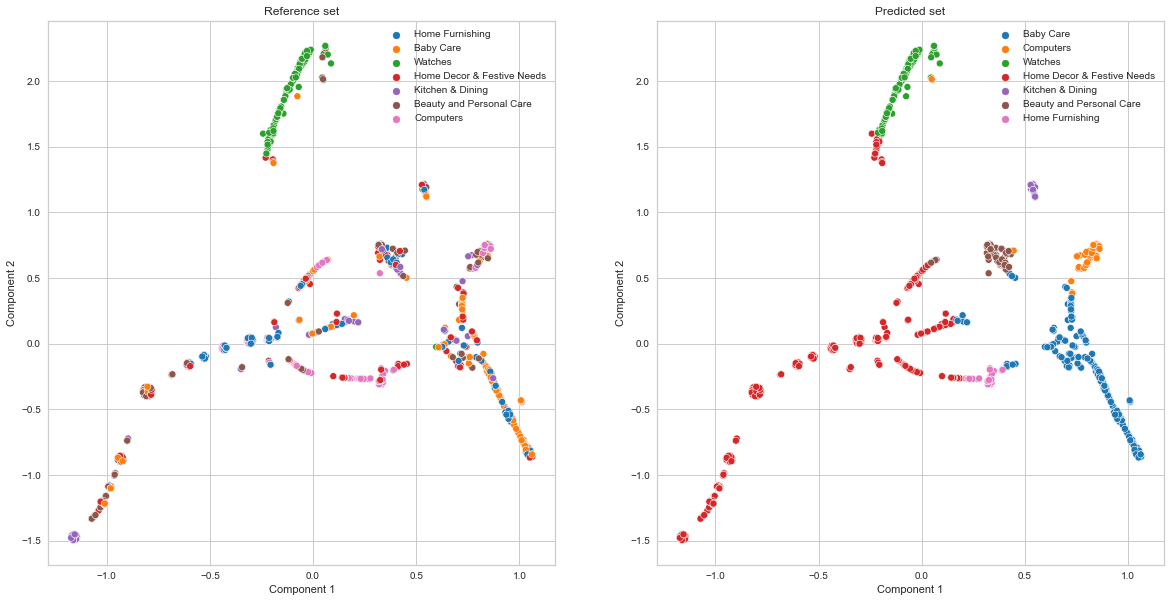

In [61]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

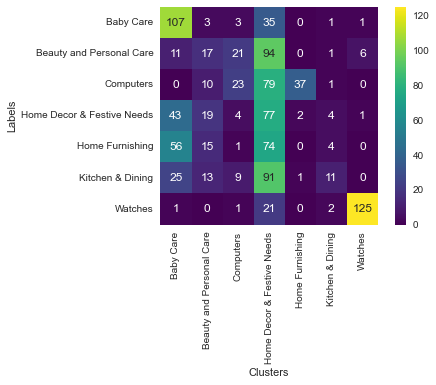

In [62]:
matrice_de_confusion(y_test, y_pred)

### NMF

In [63]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=data['cat_0'].nunique(),
          random_state=1,
          alpha=.1,
          l1_ratio=.5,
          init='nndsvd'
          )

In [64]:
# NMF is able to use tf-idf
# We re-use the TF-IDF vectorizer from above

nmf_model = make_pipeline(tfidf, nmf)

nmf_ft = nmf_model.fit_transform(data['description'])
print(nmf_ft.shape)

(1050, 7)


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


In [65]:
nmf_ft

array([[0.        , 0.        , 0.00294897, ..., 0.        , 0.15989442,
        0.        ],
       [0.01029089, 0.00242832, 0.        , ..., 0.        , 0.10412072,
        0.        ],
       [0.01726303, 0.        , 0.        , ..., 0.        , 0.08546456,
        0.00091248],
       ...,
       [0.0206515 , 0.00029593, 0.        , ..., 0.03199626, 0.        ,
        0.        ],
       [0.02218247, 0.00019898, 0.        , ..., 0.04055363, 0.        ,
        0.        ],
       [0.0274727 , 0.00160149, 0.        , ..., 0.04528157, 0.        ,
        0.        ]])

In [66]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words=20)

Topic 0:
com flipkart shipping genuine cash delivery free buy product guarantee replacement day set combo online abstract towel blanket single double
Topic 1:
watch analog men discount india great woman online dial guarantee replacement strap day com flipkart boy maximum cash genuine shipping
Topic 2:
mug coffee ceramic prithish perfect tea printland one gift get ml bring also happy together presented mm wardrobe serve fantastic
Topic 3:
baby girl detail fabric cotton dress boy sleeve neck shirt ideal pattern casual fit printed wash occasion content short general
Topic 4:
showpiece cm best online guarantee price replacement day genuine shipping cash delivery buy free product kadhai handicraft brass buddha led
Topic 5:
cm cover inch pack cushion color model design feature polyester package sale box warranty skin multicolor number material type laptop
Topic 6:
rockmantra mug ceramic permanent thrilling crafting porcelain ensuring stay start making yet dishwasher creation exclusive pick m

Le NMF arrive bien à identifier les 7 sujets différents qui correspondent bien aux catégories de produits :

In [67]:
data['cat_0'].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: cat_0, dtype: int64

In [68]:
K = get_most_probable_topic(nmf_ft)
K

array([2, 2, 2, ..., 6, 6, 6])

In [69]:
# Translation dictionnary
nmf_topics = {0: 'Beauty and Personal Care',
              1: 'Watches',
              2: 'Home Furnishing',
              3: 'Baby Care',
              4: 'Home Decor & Festive Needs',
              5: 'Computers',
              6: 'Kitchen & Dining'}
K = np.vectorize(nmf_topics.get)(K)
y_pred = K

In [70]:
result = adjusted_rand_score(y_test, y_pred)
result

0.14830096750234006

In [71]:
tsne_result = tsne_reduction(nmf_ft)
tsne_results['TFIDF+NMF'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


In [72]:
#result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['TFIDF+NMF'] = result

In [73]:
y_pred_results['TFIDF+NMF'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.14830096750234006


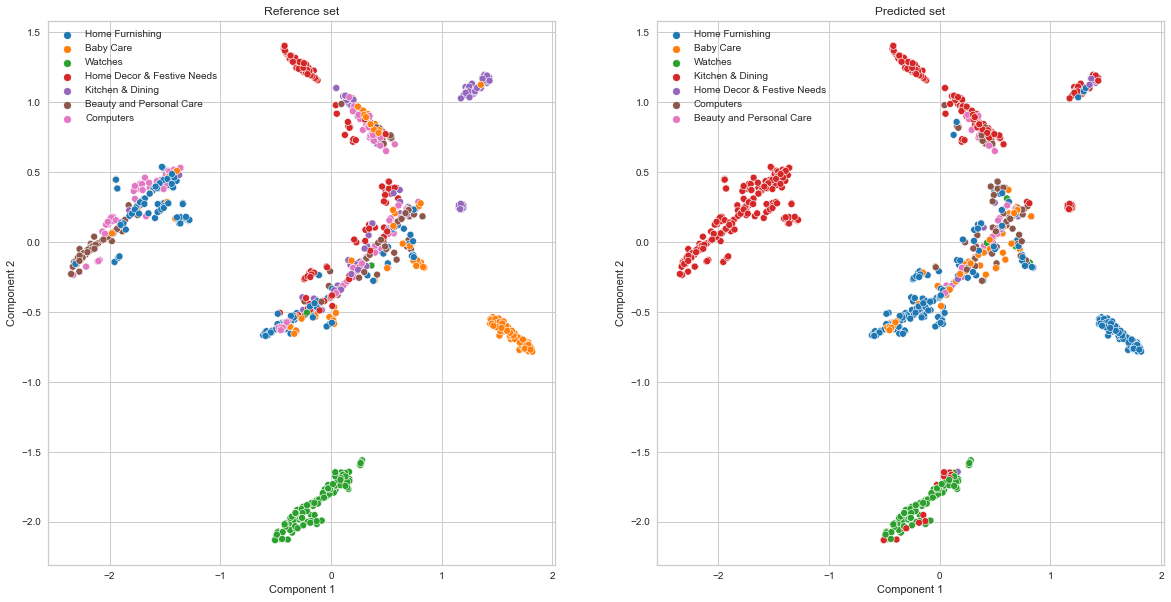

In [74]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

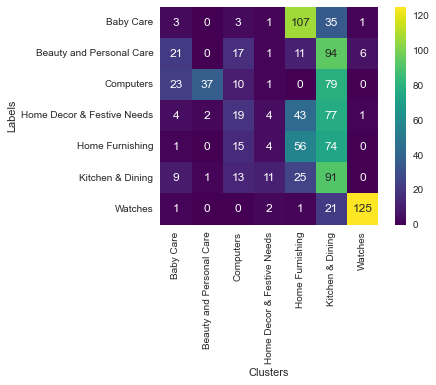

In [75]:
matrice_de_confusion(y_test, y_pred)

## Méthode supervisée

### Train Test Split

In [76]:
from sklearn.model_selection import train_test_split

X = data['description']
y = data['cat_0']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

### Apprentissage et predictions avec RandomForest

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

#acc_df = {}

model = make_pipeline(tfidf, RandomForestClassifier())
model.fit(X_train, y_train)
predictions = model.predict(X_test) #y_test = predict(x_test)

acc = accuracy_score(predictions, y_test)
print("Accuracy = {}".format(acc))
ARI = adjusted_rand_score(predictions, y_test)
print("ARI = {}".format(ARI))
ari_results['TFIDF+RFC'] = ARI

#acc_df['TFIDF_MNB'] = acc

Accuracy = 0.9285714285714286
ARI = 0.8460228248367501


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(210, 2)


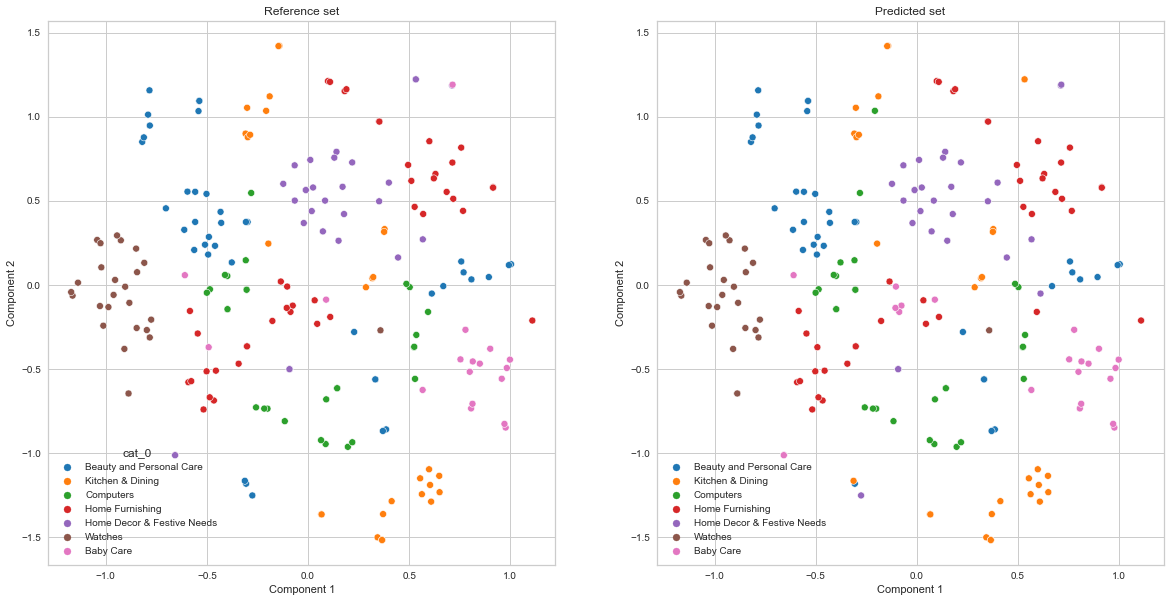

In [78]:
tfidf_rfc_ft = tfidf.fit_transform(X_test)
tfidf_rfc_df = pd.DataFrame(tfidf_rfc_ft.toarray(), columns=tfidf.get_feature_names())

tfidf_rfc_tsne_result = tsne_reduction(tfidf_rfc_df)
tsne_visualization(tfidf_rfc_tsne_result, predictions, y_test,
                   data, nc=data['cat_0'].unique())

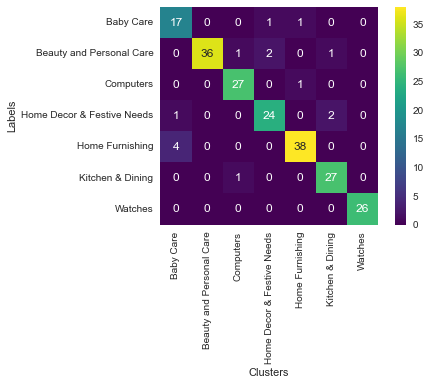

In [79]:
matrice_de_confusion(y_test, predictions)

## Comparaison des résultats

([<matplotlib.axis.XTick at 0x166bd4fd0>,
 [Text(0, 0, 'BOW+KMeans'),
  Text(1, 0, 'TFIDF+KMeans'),
  Text(2, 0, 'BOW+LDA'),
  Text(3, 0, 'TFIDF+NMF'),
  Text(4, 0, 'TFIDF+RFC')])

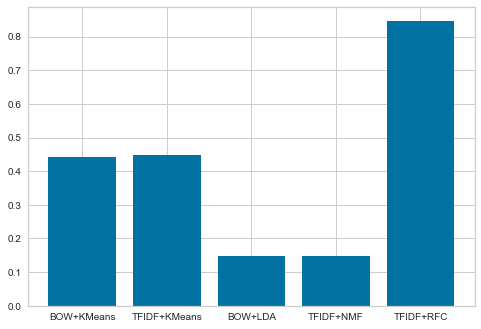

In [80]:
plt.bar(range(len(ari_results)), list(ari_results.values()), align='center')
plt.xticks(range(len(ari_results)), list(ari_results.keys()))

In [81]:
# Preprocessing
# lower
# punctation
# stopwords
# lemmatizer

# Extraire features des textes
# 1. word2vec (transfer learning)
# 2. TF-IDF
# (3. Bag of words)

# Réduction de dimension (voir si on a une bonne réduction de variable)
# 1. PCA
# 2. TSNE

# Méthodes de clustering
# 1. LDA non supervisé
# 2. NMF non supervisé
# 3. Bayesian supervisé (correspond pas au besoin)

# Métriques
# ARI, Silhouette, Confusion Matrix


# A l'issue de tous les tests faire un pipeline

# Prétraitement
# Redimensionner meme taille, retirer les couleurs, les bruits (utiliser des filtres)

# Feature extraction
# SIFT / ORB / SURF


# CNN et VGG16
# Tester les rotations d'images etc

In [82]:
# TEXTE
# Tester une méthode supervisée (XGBoost ou RandomForest)

# Données images

###### Import

In [122]:
from os import listdir
from IPython.display import Image
from PIL import Image as Image_PIL
from PIL import ImageFilter
from matplotlib.image import imread
from matplotlib.pyplot import imshow
import cv2
import keras

## Affichage d'exemples d'images

In [123]:
path = "/Users/louisrageot/Desktop/OC DS/Projet 6 - Classifiez automatiquement des biens de consommation/Livrables/Flipkart/Images/"
list_photos = data['image'].apply(lambda x: path+str(x)).to_list()
print(len(list_photos))

1050


In [160]:
# Test sample
img_sample = data.sample(1)
img_sample['image'] = img_sample['image'].apply(
    lambda x: 'Flipkart/Images/'+str(x))
# Random image from the img_sample dataframe
url = img_sample.iloc[0]['image']

In [161]:
# Load the image
image = cv2.imread(url)

# Convert the training image to RGB
training_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the training image to gray scale
training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

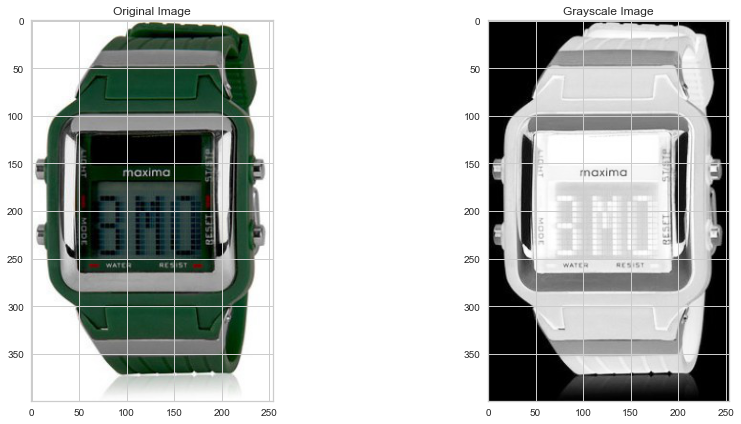

In [162]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(15, 7))

plots[0].set_title("Original Image")
plots[0].imshow(training_image)

plots[1].set_title("Grayscale Image")
plots[1].imshow(training_gray)

In [163]:
image.shape

(400, 254, 3)

## Détermination et affichage des descripteurs SIFT

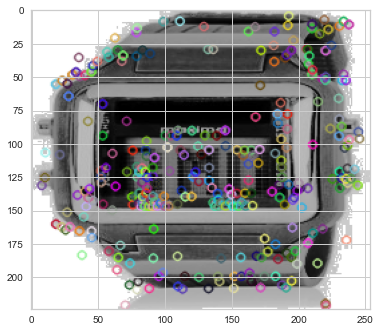

Descripteurs :  (343, 128)

[[ 33.   0.   0. ...   0.   0.   0.]
 [  3.   0.   9. ...   0.   0.   0.]
 [  0.  41.  59. ...   0.   0.   0.]
 ...
 [ 11.  77.  89. ...   0.   6.  31.]
 [ 20. 125. 101. ...   0.   0.   2.]
 [ 18. 131.  51. ...   0.   0.  11.]]


In [164]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(url, 0)  # convert in gray
# Reshape keeping the proportions
size = 224  # same as VGG16
h, w = image.shape[:2]
if h > w:
    aspect = h // size
    dim = (int(w//aspect), size)
elif h < w:
    aspect = w // size
    dim = (size, int(h//aspect))
else:
    dim = (size, size)
image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
# ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

## Pré-traitement des images via SIFT

### Créations des descripteurs de l'ensemble des images

In [92]:
# identification of key points and associated descriptors
import time
sift = cv2.xfeatures2d.SIFT_create()
sift_keypoints = []
temps1 = time.time()

for image in list_photos:
    image = cv2.imread(image, 0)  # convert in gray

    # Reshape keeping the proportions
    size = 224  # same as VGG16
    h, w = image.shape[:2]
    if h > w:
        aspect = h // size
        dim = (int(w//aspect), size)
    elif h < w:
        aspect = w // size
        dim = (size, int(h//aspect))
    else:
        dim = (size, size)
    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1 = time.time()-temps1
print("temps de traitement SIFT descriptor : ",
      "%15.2f" % duration1, "secondes")


Nombre de descripteurs :  (307618, 128)
temps de traitement SIFT descriptor :            20.79 secondes


/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Création de clusters de descripteurs (ie. Bag of Visual Words)

In [93]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init='k-means++')
#kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1 = time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  555
Création de 555 clusters de descripteurs ...
temps de traitement kmeans :             4.42 secondes


### Création des features des images
Pour chaque image :
- Prédiction des numéros de cluster de chaque descripteur
- Création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [94]:
# Creation of histograms (features)
temps1 = time.time()


def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1 = time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.13 secondes


### Réduction PCA

In [95]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.95)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 555)
Dimensions dataset après réduction PCA :  (1050, 321)


### Réduction T-SNE

In [96]:
tsne_result = tsne_reduction(feat_pca)
tsne_results['SIFT'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


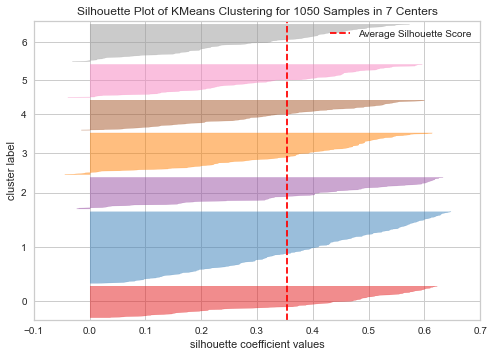

ARI = 0.03298282321868395


In [97]:
result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['SIFT'] = result

In [98]:
#y_pred_results['TFIDF+NMF'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.03298282321868395


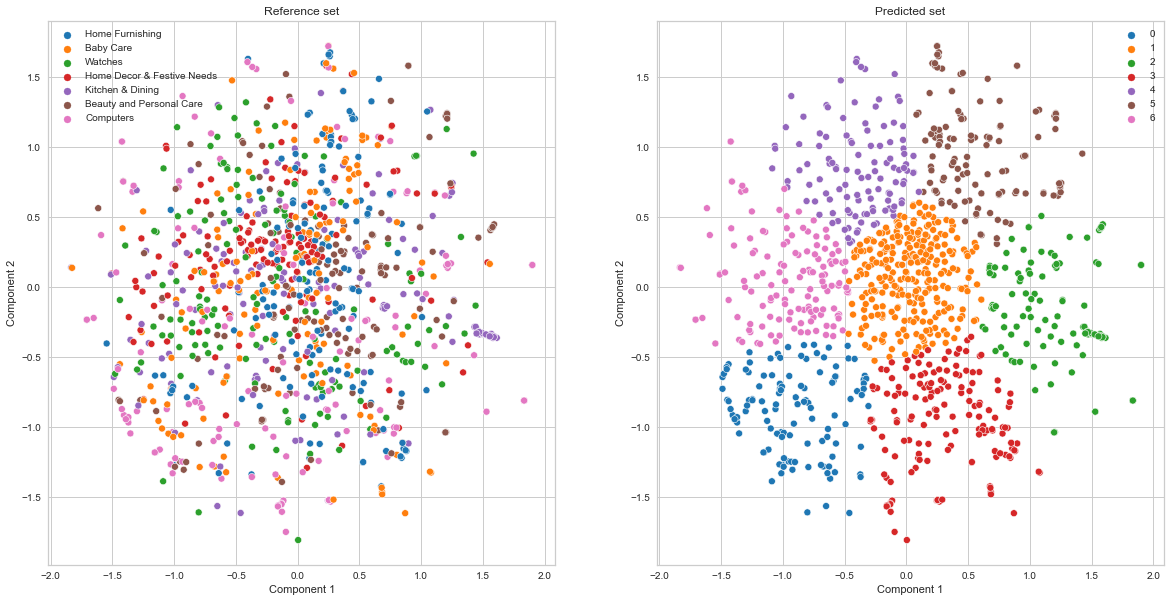

In [99]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

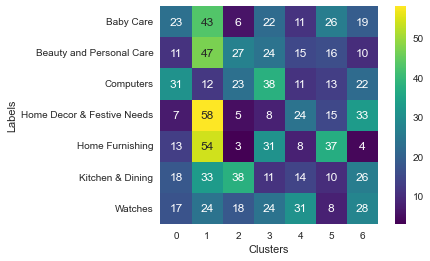

In [100]:
matrice_de_confusion(y_test, y_pred)

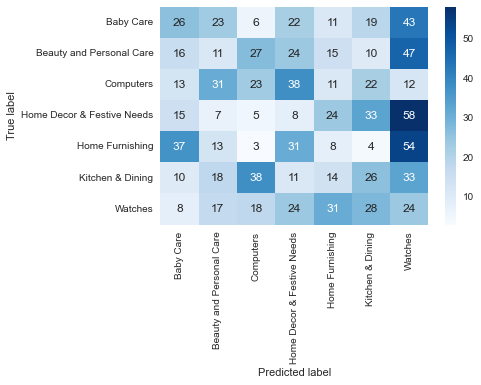

In [101]:
graph_conf_matrix(y_test, y_pred, data=data, corresp=[1,6,2,3,4,0,5])

# CNN Transfer learning (VGG16)

Mettre en oeuvre une démarche de pré-traitement des images basée sur du CNN Transfer Learning :
- Utiliser un modèle de deep learning pré-entraîné sur des millions d'images
- Enlever la dernière couche du modèle, et sans entraînement, faire un predict pour chaque image afin de créer des features 
- Réaliser ensuite la démarche de réduction de dimension T-SNE

## Test avec une image

In [165]:
# example of using the vgg16 model as a feature extraction model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from pickle import dump

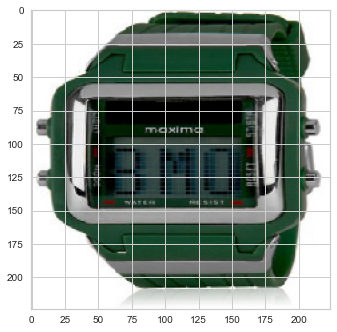

In [166]:
# load an image from file
image = load_img(url, target_size=(224, 224))

plt.imshow(image)

In [104]:
# convert the image pixels to a numpy array
image = img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [105]:
# prepare the image for the VGG model
image = preprocess_input(image)
image.shape

(1, 224, 224, 3)

In [106]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

2021-12-03 18:01:50.944294: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-03 18:01:50.945064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [107]:
# get extracted features
features = model.predict(image)
print(features.shape)

(1, 4096)


2021-12-03 18:01:53.444466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-03 18:01:53.448483: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-03 18:01:53.527007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [108]:
features

array([[0.       , 0.       , 0.       , ..., 1.7616484, 0.       ,
        0.       ]], dtype=float32)

## Utilisation comme Feature Extractor Preprocessor

Sur l'ensemble des images - Méthode non supervisée (KMeans)

### Preprocess

In [109]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [110]:
def preprocessing_VGG16(image):
    # load an image from file
    image = load_img(image, target_size=(224, 224))
    #plt.imshow(image)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    return image

In [111]:
def predict_VGG16(image, model=model):
    # get extracted features
    features = model.predict(image)
    #print(features.shape)
    return features

### Predictions

In [112]:
def batch_run_VGG16(dataset):

    features_vgg16 = []

    for img in dataset:
        img = preprocessing_VGG16(img)
        features = predict_VGG16(img)
        features_vgg16.append(features)

    # tranform to array
    features_vgg16 = np.array(features_vgg16)
    features_vgg16.shape

    # reshape
    features_vgg16 = features_vgg16.reshape(-1, features_vgg16.shape[2])
    features_vgg16.shape

    return features_vgg16

In [113]:
X = list_photos
features_vgg16 = batch_run_VGG16(X)

2021-12-03 18:01:55.817394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/PIL/Image.py:2911: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [114]:
features_vgg16.shape

(1050, 4096)

### Réduction PCA

In [115]:
print("Dimensions dataset avant réduction PCA : ", features_vgg16.shape)
pca = PCA(n_components=0.95)
feat_pca = pca.fit_transform(features_vgg16)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 4096)
Dimensions dataset après réduction PCA :  (1050, 490)


### Réduction T-SNE

In [116]:
tsne_result = tsne_reduction(feat_pca)
tsne_results['VGG16_Feature_Extractor'] = tsne_result

/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/louisrageot/miniforge3/envs/vir_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(1050, 2)


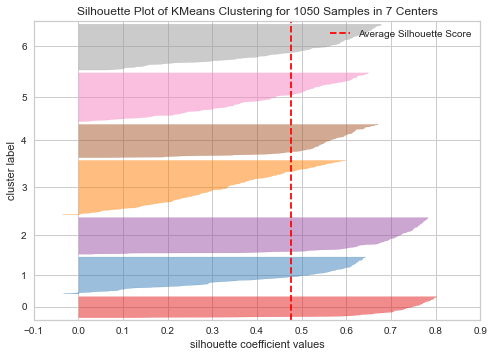

ARI = 0.4861932307425071


In [117]:
result, y_pred, kmeans_model = KMeans_clustering(tsne_result, data, 'cat_0')
ari_results['VGG16_Feature_Exctrator'] = result

In [118]:
#y_pred_results['TFIDF+NMF'] = y_pred
print('Adjusted Rand Index = {}'.format(result))

y_test = data['cat_0'].values

Adjusted Rand Index = 0.4861932307425071


### Visualisation T-SNE

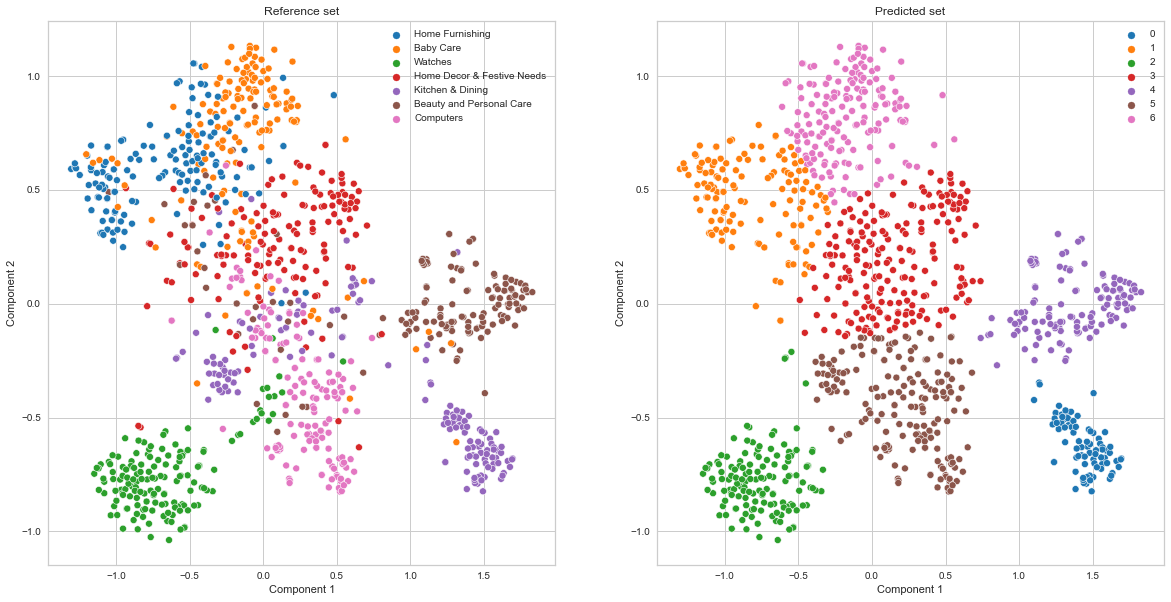

In [119]:
tsne_visualization(tsne_result, y_pred, y_test,
                   data, nc=data['cat_0'].unique())

### Matrice de confusion

Correspondance des clusters :  [5 4 6 3 1 2 0]


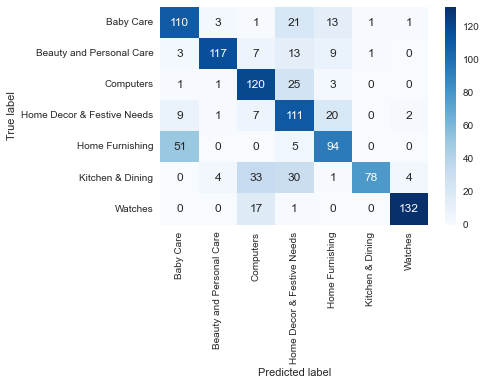

In [120]:
graph_conf_matrix(y_test, y_pred, data=data)

## Comparaison des résultats

([<matplotlib.axis.XTick at 0x14fbd0970>,
 [Text(0, 0, 'BOW+KMeans'),
  Text(1, 0, 'TFIDF+KMeans'),
  Text(2, 0, 'BOW+LDA'),
  Text(3, 0, 'TFIDF+NMF'),
  Text(4, 0, 'TFIDF+RFC'),
  Text(5, 0, 'SIFT'),
  Text(6, 0, 'VGG16_Feature_Exctrator')])

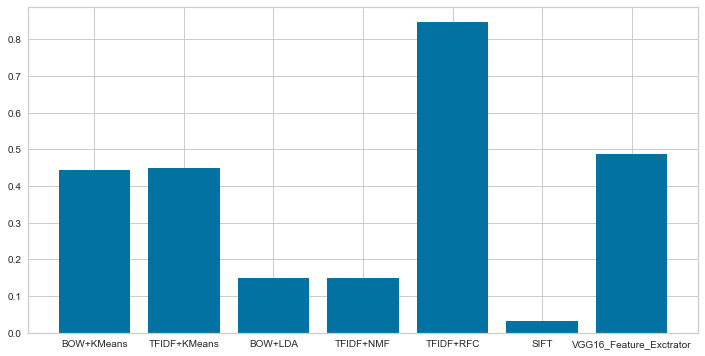

In [121]:
plt.figure(figsize=(12,6))
plt.bar(range(len(ari_results)), list(ari_results.values()), align='center')
plt.xticks(range(len(ari_results)), list(ari_results.keys()))

# Synthèse et conclusion

Pistes d'amélioration :
- Utiliser d'autres colonnes de textes pas uniquement la description (le titre par exemple)
- Essayer d'autres algorithme ex: ORB / SURF

Synthèse :
- Utilisation d’un dataset exploitable
- Analyse exploratoire
- Analyse des données textes et tests de plusieurs méthodes
- Analyse des données images et tests de plusieurs méthodes

Les méthodes supervisées surpassent les méthodes supervisées mais nécessitent un entraînement non négligeable.

Conclusion :
- Possibilité de prédire automatiquement la catégorie d’un article nécessitant néanmoins des ajustements
-  Faisabilité validée et beaucoup de potentiel avec le Transfert Learning (piste à privilégier)